In [1]:
import pyspark

In [2]:
!pip3 install findspark

  Using cached https://files.pythonhosted.org/packages/b1/c8/e6e1f6a303ae5122dc28d131b5a67c5eb87cbf8f7ac5b9f87764ea1b1e1e/findspark-1.3.0-py2.py3-none-any.whl


In [3]:
import findspark

In [4]:
findspark.init('/home/spark-2.4.4-bin-hadoop2.7/')

In [5]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [6]:
#This can only be run once (but why is that so ?)
sc = SparkContext()

In [7]:
#What are each of these in details ?
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [8]:
socket_stream = ssc.socketTextStream("127.0.0.1",5556)

In [9]:
#A properly commented out version of this notebook would do much good
lines = socket_stream.window(20)

In [10]:
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [11]:
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

### The Tweet reader has to be started at this point

In [12]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
# Only works for Jupyter Notebooks!
%matplotlib inline

In [13]:
ssc.start()

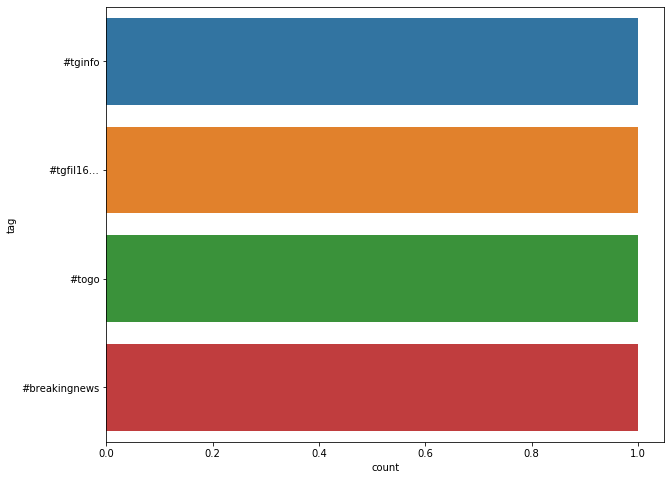

In [15]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1

In [16]:
ssc.stop()